# Exploratory Data Analysis of FDM 3D-Printing Parameters and Performance Metrics

### Introduction

In this notebook, we explore an FDM 3D-printing dataset containing both mechanical (e.g., layer height, wall thickness, and infill pattern) and thermal (e.g., nozzle/bed temperature and fan speed) process settings and surface-finish and mechanical performance outcomes. Our goal is to characterize the distributions of each target, identify key drivers and correlations among inputs, and compare how design choices (e.g., material and infill pattern) affect print quality. These insights will guide the development of robust predictive models and inform process‐optimization strategies in the future.  

- Dataset source: https://www.kaggle.com/datasets/afumetto/3dprinter?select=data.csv

### Load the dataset

In [1]:
import pandas as pd


# Load the dataset from defined path
FILENAME = 'data.csv'
df = pd.read_csv(FILENAME)

# Inspect the data
print(f'Shape: {df.shape}.')
df.head()

Shape: (50, 12).


,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,tension_strenght,elongation
0,0.02,8,90,grid,220,60,40,abs,0,25,18,1.2
1,0.02,7,90,honeycomb,225,65,40,abs,25,32,16,1.4
2,0.02,1,80,grid,230,70,40,abs,50,40,8,0.8
3,0.02,4,70,honeycomb,240,75,40,abs,75,68,10,0.5
4,0.02,6,90,grid,250,80,40,abs,100,92,5,0.7


### Define exploratory questions

- Q1. What do the distributions of our three targets look like? Are they symmetric or skewed?
- Q2. What are the most common values of categorical variables?
- Q3. Which input process parameters exhibit the strongest positive/negative linear correlations with each target variable? Are any predictors highly inter‐correlated?
- Q4. How do our targets differ by material and infill pattern?

### Standardize column names and values

First let's ensure consistency in the columns and correct for the misspellled target column.

In [2]:
# Ensure all columns are lower-case (as some datasets are mixed)
for col in df:
    df.rename(columns={col: col.lower()}, inplace=True)

# Rename misspelled column
df.rename(columns={'tension_strenght': 'tension_strength'}, inplace=True)

# Capitalize material column
df['material'] = df['material'].str.upper()

### Handle duplicate values

In [3]:
num_duplicates = df.duplicated().sum()
print(f'There are {num_duplicates} duplicate rows.')

There are 0 duplicate rows.


There are not any duplicate rows. That's great!

### Handle missing values

In [4]:
# Overall missing counts for quick health check
rows_with_missing = df.isna().any(axis=1).sum()
total_missing = df.isna().sum().sum()

print(f"Rows with at least one missing: {rows_with_missing} / {len(df)}.")
print(f"Total missing values: {total_missing}.")

Rows with at least one missing: 0 / 50.
Total missing values: 0.


There aren't any rows with missing values. That's great!

### Explore unique inputs

Next let's examine the different unique values for each of the input columns.

In [5]:
import numpy as np


# Differentiate the inputs from the 3 targets
targets = ['roughness', 'tension_strength', 'elongation']
inputs = [col for col in df if col not in targets]
num_targets, num_inputs = len(targets), len(inputs)

# Examine unique values for each of the inputs
unique_vals = {}
for col in inputs:
    unique_vals[col] = df[col].unique()

for k, v in unique_vals.items():
    print(f'{k} ({len(v)} unique): {np.sort(v)}')

layer_height (5 unique): [0.02 0.06 0.1  0.15 0.2 ]
wall_thickness (10 unique): [ 1  2  3  4  5  6  7  8  9 10]
infill_density (9 unique): [10 20 30 40 50 60 70 80 90]
infill_pattern (2 unique): ['grid' 'honeycomb']
nozzle_temperature (9 unique): [200 205 210 215 220 225 230 240 250]
bed_temperature (5 unique): [60 65 70 75 80]
print_speed (3 unique): [ 40  60 120]
material (2 unique): ['ABS' 'PLA']
fan_speed (5 unique): [  0  25  50  75 100]


The first thing that stands out is the deliberate discretization of nearly every process parameter:  

- **Layer height:** 5 very fine-to-coarse settings (0.02 - 0.20 mm)  
- **Wall thickness:** 10 integer values (1 - 10 mm)  
- **Infill density:** 9 evenly spaced fractions (10% - 90%)  
- **Infill pattern:** 2 patterns (grid and honeycomb) - grid is a common go-to, and honeycomb is common for maximizing strength
- **Nozzle temperature:** 5 °C increments from 200 – 230 °C with additional points at 240 °C and 250 °C  
- **Bed temperature:** 5 evenly spaced temperatures (60 - 80 °C)  
- **Print speed:** 3 unevenly distibuted values (40, 60, 120 mm/s)  
- **Material:** 2 materials (ABS and PLA). These materials are the most common materials used in desktop FDM  
- **Fan speed:** 5 evenly distributed levels (0% - 100%)

### Summary statistics of features and targets

In [6]:
# Descriptive stats for all numeric columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
layer_height,50.0,0.106,0.064397,0.02,0.06,0.10,0.150,0.2
wall_thickness,50.0,5.220,2.922747,1.00,3.00,5.00,7.000,10.0
infill_density,50.0,53.400,25.363480,10.00,40.00,50.00,80.000,90.0
nozzle_temperature,50.0,221.500,14.820353,200.00,210.00,220.00,230.000,250.0
bed_temperature,50.0,70.000,7.142857,60.00,65.00,70.00,75.000,80.0
print_speed,50.0,64.000,29.692300,40.00,40.00,60.00,60.000,120.0
fan_speed,50.0,50.000,35.714286,0.00,25.00,50.00,75.000,100.0
roughness,50.0,170.580,99.034129,21.00,92.00,165.50,239.250,368.0
tension_strength,50.0,20.080,8.925634,4.00,12.00,19.00,27.000,37.0
elongation,50.0,1.672,0.788188,0.40,1.10,1.55,2.175,3.3


In [7]:
# Detailed stats on the targets
df[targets].describe().T

,count,mean,std,min,25%,50%,75%,max
roughness,50.0,170.580,99.034129,21.0,92.0,165.50,239.250,368.0
tension_strength,50.0,20.080,8.925634,4.0,12.0,19.00,27.000,37.0
elongation,50.0,1.672,0.788188,0.4,1.1,1.55,2.175,3.3


### Q1. What do the distributions of our three targets look like? Are they symmetric or skewed?

In [8]:
# Compute summary statistics and skewness
print(df[['roughness','tension_strength','elongation']].describe())
print("\nSkewness:")
print(df[['roughness','tension_strength','elongation']].skew())

        roughness  tension_strength  elongation
count   50.000000         50.000000   50.000000
mean   170.580000         20.080000    1.672000
std     99.034129          8.925634    0.788188
min     21.000000          4.000000    0.400000
25%     92.000000         12.000000    1.100000
50%    165.500000         19.000000    1.550000
75%    239.250000         27.000000    2.175000
max    368.000000         37.000000    3.300000

Skewness:
roughness           0.308656
tension_strength    0.082068
elongation          0.507704
dtype: float64


<ul>
  <li>Roughness
    <ul>
      <li>Range: 21 - 368 &micro;m</li>
        <li>Mean: 170.58 &micro;m, Median: 165.50 &micro;m</li>
        <li>Skewness: +0.31</li>
        <li><b>Interpretation:</b> The mean is slightly above the median and the positive skewness confirms a <b>modest right-tail</b>. In other words, most prints cluster around 90-240 &micro;m, but there are a few high-roughness outliers pulling the tail to the right.</li>
    </ul>
  </li>
    <li>Tension Strength
        <ul>
      <li>Range: 4 - 37 MPa</li>
        <li>Mean: 20.1 MPa, Median: 19.0 MPa</li>
        <li>Skewness: +0.08</li>
        <li><b>Interpretation:</b> The mean and median are almost identical and the skewness (although positive) is nearly zero. This indicates an <b>approximately symmetric</b> (i.e., bell-shaped) distribution of strength values.</li>
        </ul>
    </li>
    <li>Elongation
        <ul>
      <li>Range: 0.4 - 3.3 mm/mm</li>
        <li>Mean: 1.67 mm/mm, Median: 1.55 mm/mm</li>
        <li>Skewness: +0.51</li>
        <li><b>Interpretation:</b> The mean is above the median and the positive skewness show a <b>moderate right-skew.</b> In other words, most of the samples are between ~1.1-2.2 mm/mm, but a tail extends toward higher elongation values (up to 3.3 mm/mm).</li>
        </ul>
    </li>
</ul>

To confirm our interpretation, let us look at the distributions and boxplots of the three target variables.  
Let's visualize the distribution of the targets using a histogram. We can make the skewness (or symmetry) immediately visible by creating a boxplot and examining the relative lengths of the whiskers and the box.

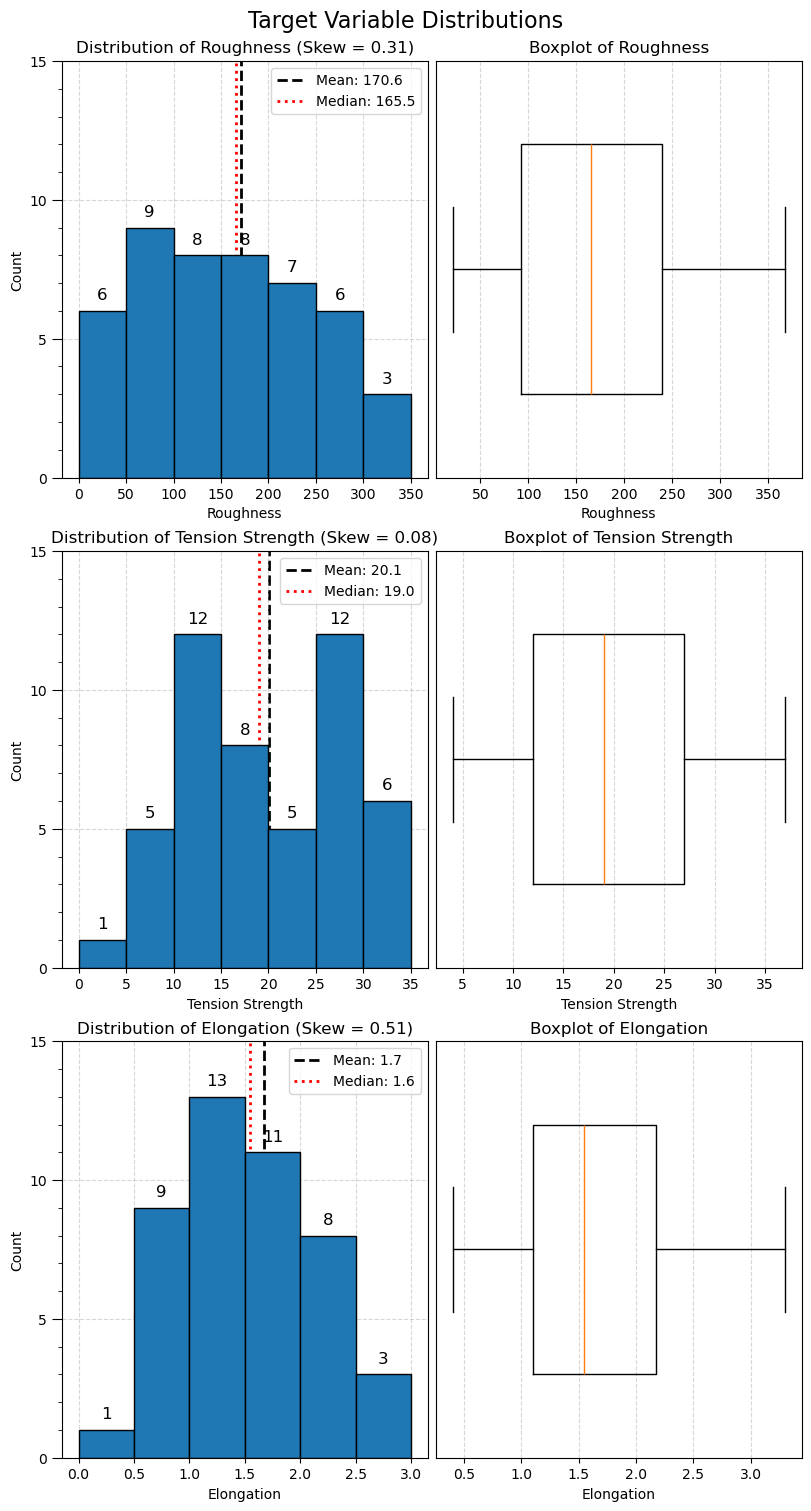

In [9]:
import math

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MultipleLocator


# Define custom bin edges for each target
bin_specs = {
    'roughness': np.arange(0, 380, 50),
    'tension_strength': np.arange(0, 40, 5),
    'elongation': np.arange(0, 3.5, 0.5),
}

# Compute a shared ymax rounded up to the nearest major_step
major_step = 5  # labeled ticks
minor_step = 1  # unlabeled ticks

max_count = max(
    np.histogram(df[col].dropna(), bins=bins)[0].max()
    for col, bins in bin_specs.items()
)
ymax = math.ceil(max_count / major_step) * major_step

# Create a grid of subplots: one row per target, two columns (hist + box)
num_targets = len(targets)
fig, axes = plt.subplots(
    num_targets,
    2,
    figsize=(8, 5 * num_targets),
    sharey=False,
    constrained_layout=True
)

# If there's only one target, make axes iterable
if num_targets == 1:
    axes = np.array([axes])

for i, col in enumerate(targets):
    data  = df[col].dropna()
    mean = data.mean()
    median = data.median()
    skewness = data.skew()
    bins  = bin_specs[col]
    label = col.replace('_', ' ').title()

    # Histogram
    ax_hist = axes[i, 0]   
    counts, edges, patches = ax_hist.hist(
        data, bins=bins, edgecolor='black', zorder=2
    )
    ax_hist.axvline(mean, color='black', linestyle='--', linewidth=2, label=f'Mean: {mean:.1f}', zorder=0)
    ax_hist.axvline(median, color='red', linestyle=':', linewidth=2, label=f'Median: {median:.1f}', zorder=0)

    ax_hist.set_ylim(0, ymax)
    ax_hist.yaxis.set_major_locator(MultipleLocator(major_step))
    ax_hist.yaxis.set_minor_locator(MultipleLocator(minor_step))
    ax_hist.tick_params(axis='y', which='major', length=7)
    ax_hist.tick_params(axis='y', which='minor', length=3)
    
    # Annotate each bar
    for count, left, patch in zip(counts, edges, patches):
        if count > 0:
            ax_hist.text(
                left + patch.get_width() / 2,
                count + ymax * 0.02,
                str(int(count)),
                ha='center', va='bottom',
                fontsize=12,
                zorder=3
            )
    
    ax_hist.set_xlabel(label)
    ax_hist.set_ylabel('Count')
    ax_hist.set_title(f'Distribution of {label} (Skew = {skewness:.2f})')
    ax_hist.set_axisbelow(True)
    ax_hist.grid(True, linestyle='--', alpha=0.5, zorder=1)
    ax_hist.legend()
    
    # Horizontal boxplot
    ax_box = axes[i, 1]
    ax_box.set_axisbelow(True)
    ax_box.grid(axis='x', linestyle='--', alpha=0.5, zorder=1)
    ax_box.boxplot(data, vert=False, widths=0.6, zorder=2)
    ax_box.set_title(f'Boxplot of {label}')
    ax_box.set_xlabel(label)
    ax_box.set_yticks([])  # Remove the single y-tick

fig.suptitle('Target Variable Distributions', fontsize=16)
plt.show()

### A1. Roughness and elongation both show positive skew (i.e., more observations at lower values with a longer right‐hand tail), whereas the tensile strength distribution is essentially symmetric, with its mean and median nearly equivalent.

### Q2. What are the most common values of categorical variables?

To determine the most common values of categorical variables, we first must determine categorical variables. We we can use one of multiple rules for doing so. For example, we can look at the data type of the columns or we can consider those with low cardinality to be categorical.

In [10]:
# By dtype
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print(f'The categorical columns (by data type) are: {cat_cols}.')

# Determine number of unique values in each column (was done earlier)
num_unique = np.sort([df[col].nunique() for col in df.columns])
print(f'The number of unique values in each column (sorted) are: {num_unique}.')

The categorical columns (by data type) are :['infill_pattern', 'material'].
The number of unique values in each column (sorted) are: [ 2  2  3  5  5  5  9  9 10 26 27 44].


In [11]:
pot_categorical = [col for col in df.columns if df[col].nunique() == 3][0]
print(f'The potentially categorical variable is {pot_categorical}.')

The potentially categorical variable is print_speed.


Based off of the cardinality, the 'print_speed' column could be categorical. Let us only consider those which have 2 unique options for now.

In [12]:
# Identify categorical columns based on low cardinality (e.g., 2 or fewer unique values)
threshold = 2
categorical = [col for col in df.columns if df[col].nunique() <= threshold]
categorical = sorted(categorical)  # Alphabetize
num_categorical = len(categorical)
print("Categorical candidates:", categorical)

Categorical candidates: ['infill_pattern', 'material']


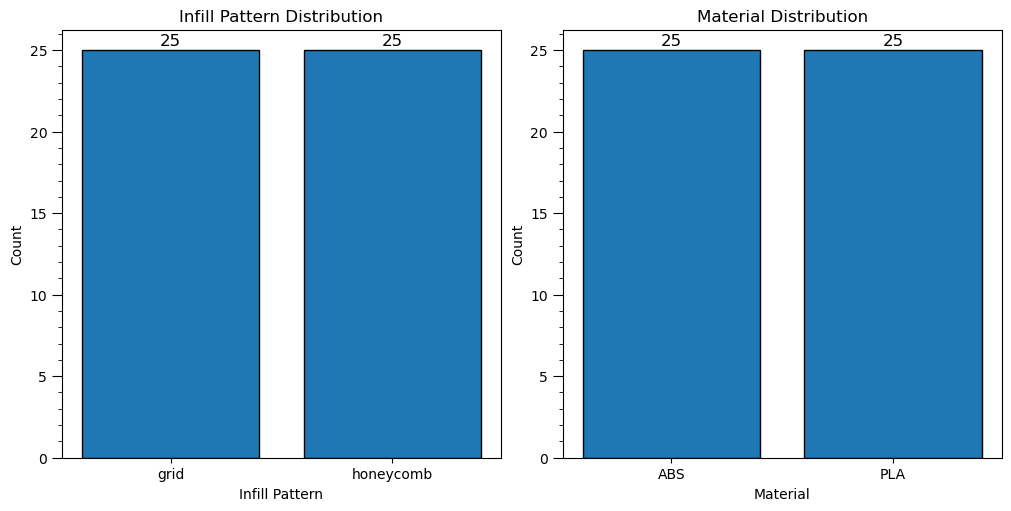

In [13]:
# Compute global tick steps from the largest category count
major_step = 5
minor_step = 1

# Set up subplots, sharing y for easy comparison
fig, axes = plt.subplots(
    1, num_categorical,
    figsize=(5 * num_categorical, 5),
    constrained_layout=True
)
if num_categorical == 1:
    axes = [axes]

# Plot and annotate each
for ax, col in zip(axes, categorical):
    col_str = col.replace('_', ' ').title()
    counts = df[col].value_counts()
    
    # Bar plot
    bars = ax.bar(
        counts.index.astype(str),
        counts.values,
        edgecolor='black'
    )

    # Tick formatting
    ax.yaxis.set_major_locator(MultipleLocator(major_step))
    ax.yaxis.set_minor_locator(MultipleLocator(minor_step))
    ax.tick_params(axis='y', which='major', length=7)
    ax.tick_params(axis='y', which='minor', length=3)

    # Annotation to show count above each bar
    max_count = counts.values.max()
    for bar in bars:
        h = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2,
            h + 0.005 * max_count,
            str(int(h)),
            ha='center',
            va='bottom',
            fontsize=12,
        )
    ax.set_xlabel(col_str)
    ax.set_ylabel('Count')
    ax.set_title(f'{col_str} Distribution')

plt.show()

### A2. The two categorical variables are (1) infill pattern and (2) material.  
- **Infill pattern:** Both **grid** and **honeycomb** occur equally often (25 each).
- **Material:** Both **ABS** and **PLA** occur equally often (25 each).

### Q3. Which input process parameters exhibit the strongest positive/negative linear correlations with each target variable? Are any predictors highly inter‐correlated?

To quantify the strength/direction of linear relationships, we compute the Pearson correlation matrix and visualize it as a heatmap. This will help us:
- Identify which process parameters are most positively or negatively correlated with each target (roughness, tensile strength, elongation).  
- Spot any strong inter‐correlations among input features that could indicate multicollinearity.  
- Guide feature selection and engineering for any later modeling steps.

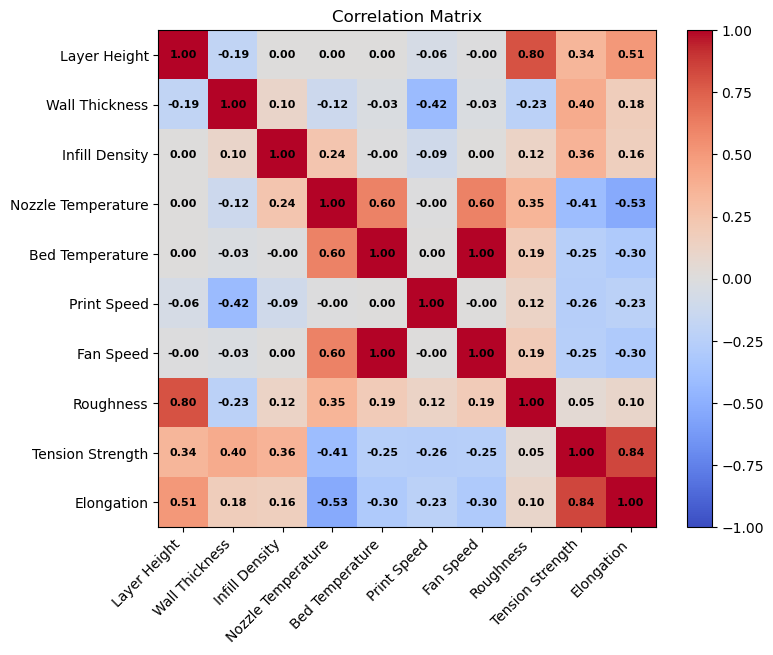

In [14]:
# Determine the correlation matrix for the numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns
corr = df[numeric_cols].corr()
numeric_cols_ref = [x.replace('_', ' ').title() for x in numeric_cols]

# Plot the heatmap with annotations
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.imshow(corr, interpolation='nearest', cmap='coolwarm', vmin=-1, vmax=1)

# Colorbar
fig.colorbar(cax, ax=ax, shrink=0.698)

# Tick labels
ax.set_xticks(range(len(numeric_cols_ref)))
ax.set_yticks(range(len(numeric_cols_ref)))
ax.set_xticklabels(numeric_cols_ref, rotation=45, ha='right')
ax.set_yticklabels(numeric_cols_ref)

# Annotate the full matrix
for i in range(len(numeric_cols_ref)):
    for j in range(len(numeric_cols_ref)):
        color = 'black' if corr.iat[i, j] < 0.0 else 'black'
        ax.text(j, i, f"{corr.iat[i, j]:.2f}", ha='center', va='center', color=color, fontsize=8, fontweight='bold')

plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

### A3. From the correlation matrix, we can see that each target is driven by a different subset of inputs:  
- **Roughness**
  - **Strongest positive:** Layer height (r $\approx$ 0.80)
  - **Moderate positive:** Nozzle temperature (r $\approx$ 0.35), bed temperature (r $\approx$ 0.19), and fan speed (r $\approx$ 0.19).
  - **Moderate negative:** Wall thickness (r $\approx$ -0.23)
- **Tension strength**
  - **Strongest positive:** Wall thickness (r $\approx$ 0.40)
  - **Moderate positive:** Infill density (r $\approx$ 0.36) and layer height (r $\approx$ 0.34).
  - **Strongest negative:** Nozzle temperature (r $\approx$ -0.41)
  - **Moderate negative:** Print speed (r $\approx$ -0.26), bed temperature (r $\approx$ -0.25), and fan speed (r $\approx$ -0.25).
- **Elongation**
  - **Strongest positive:** Layer height (r $\approx$ 0.51)
  - **Strongest negative:** Nozzle temperature (r $\approx$ -0.53)
  - **Moderate negative:** Bed temperature (r $\approx$ -0.30), fan speed (r $\approx$ -0.30), and print speed (r $\approx$ -0.23).

Among the inputs themselves, the three thermal variables (nozzle temperature bed temperature, and fan speed) are nearly redundant. Bed temperature and fan speed are perfectly correlated (r = +1.00), and both share a strong positive correlation (r $\approx$ 0.60) with nozzle temperature.

### Q4. How do our targets differ by material and infill pattern?

In [15]:
# Grouped statistics by categorical features
group_stats = df.groupby('material')[['roughness', 'tension_strength', 'elongation']].mean().reset_index()
pattern_stats = df.groupby('infill_pattern')[['roughness', 'tension_strength', 'elongation']].mean().reset_index()
print(group_stats)
print(pattern_stats)

  material  roughness  tension_strength  elongation
0      ABS     193.44             17.52       1.364
1      PLA     147.72             22.64       1.980
  infill_pattern  roughness  tension_strength  elongation
0           grid     177.28             20.00       1.636
1      honeycomb     163.88             20.16       1.708


On average, PLA prints are noticeably (1) smoother, (2) stronger in tension, and (3) more ductile than ABS.  
On average, honeycomb infill yields similar result trends, but the differences are relatively small: they are slightly smoother, marginally stronger, and slightly more ductile.  
Next, we will visualize the target variable distributions for material and infill pattern, both as scatter plots and boxplots.

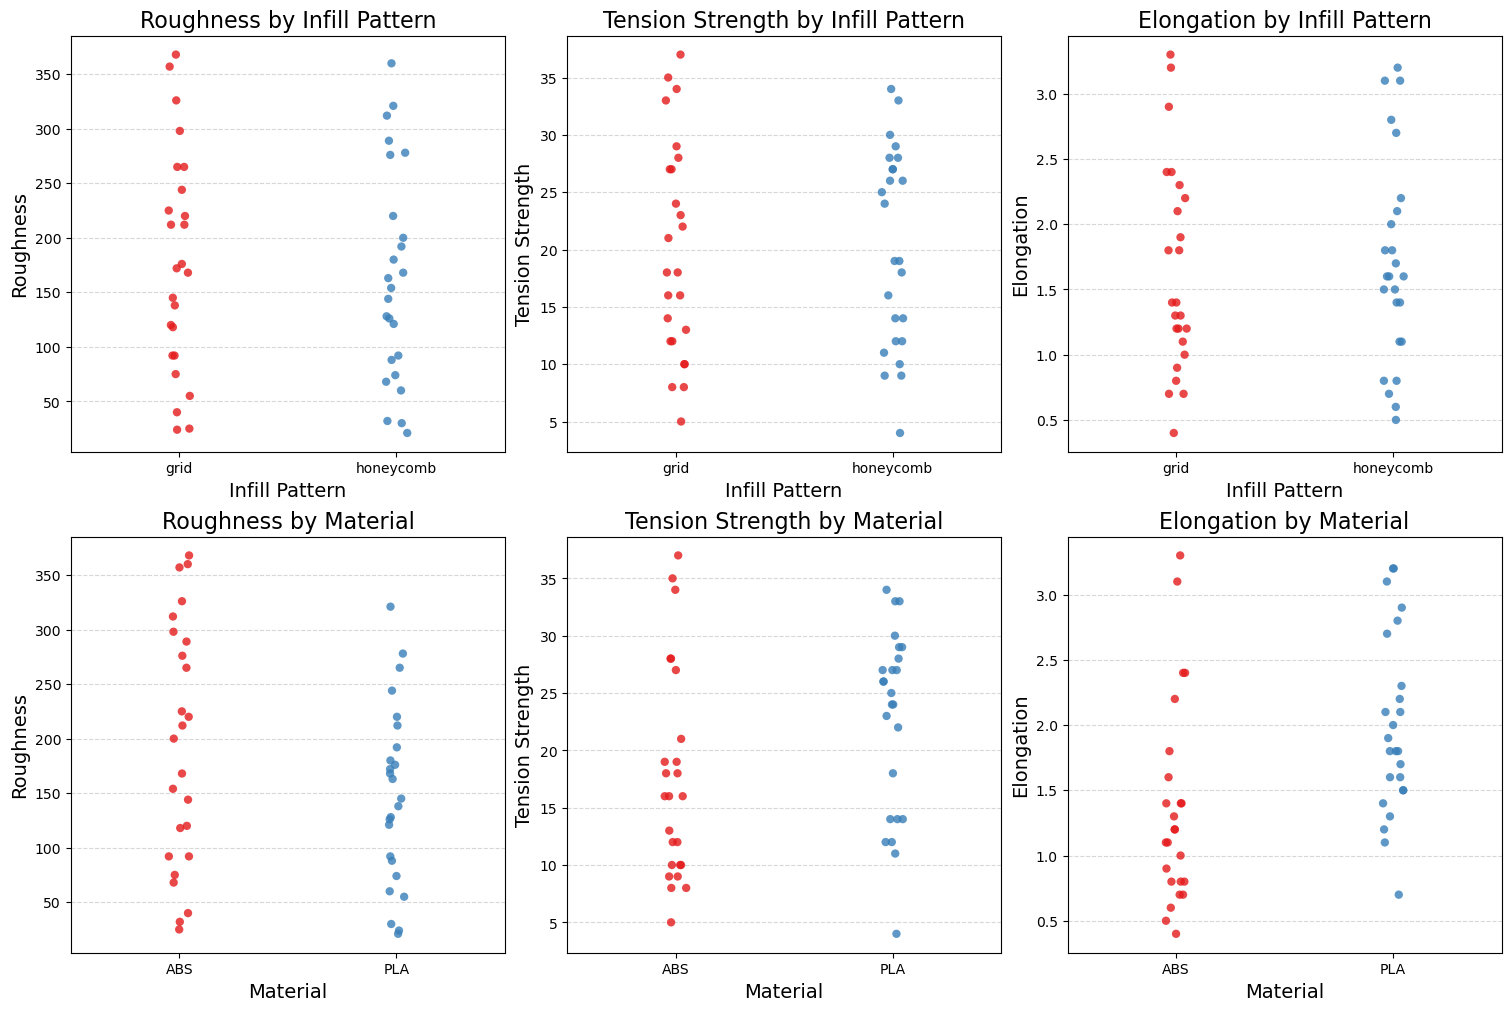

In [16]:
# Variables to group by
group_vars = ['infill_pattern', 'material']
num_targets = len(targets)

# Create subplots grid: rows for grouping vars, columns for each target
fig, axes = plt.subplots(
    len(group_vars), 
    num_targets, 
    figsize=(5 * num_targets, 5 * len(group_vars)), 
    constrained_layout=True
)

# Ensure axes is a 2D array
if axes.ndim == 1:
    axes = axes.reshape(1, -1)

# Plot each combination
for i, group in enumerate(group_vars):
    for j, col in enumerate(targets):
        ax = axes[i, j]
        sns.stripplot(
            x=group,
            y=col,
            data=df,
            jitter=0.05,
            size=6,
            hue=group,
            palette='Set1',
            edgecolor='black',
            alpha=0.8,
            dodge=False,
            ax=ax
        )
        ax.grid(axis='y', linestyle='--', alpha=0.5)
        ax.set_xlabel(group.replace('_', ' ').title(), fontsize=14)
        ax.set_ylabel(col.replace('_', ' ').title(), fontsize=14)
        ax.set_title(f'{col.replace("_", " ").title()} by {group.replace("_", " ").title()}', fontsize=16)

plt.show()

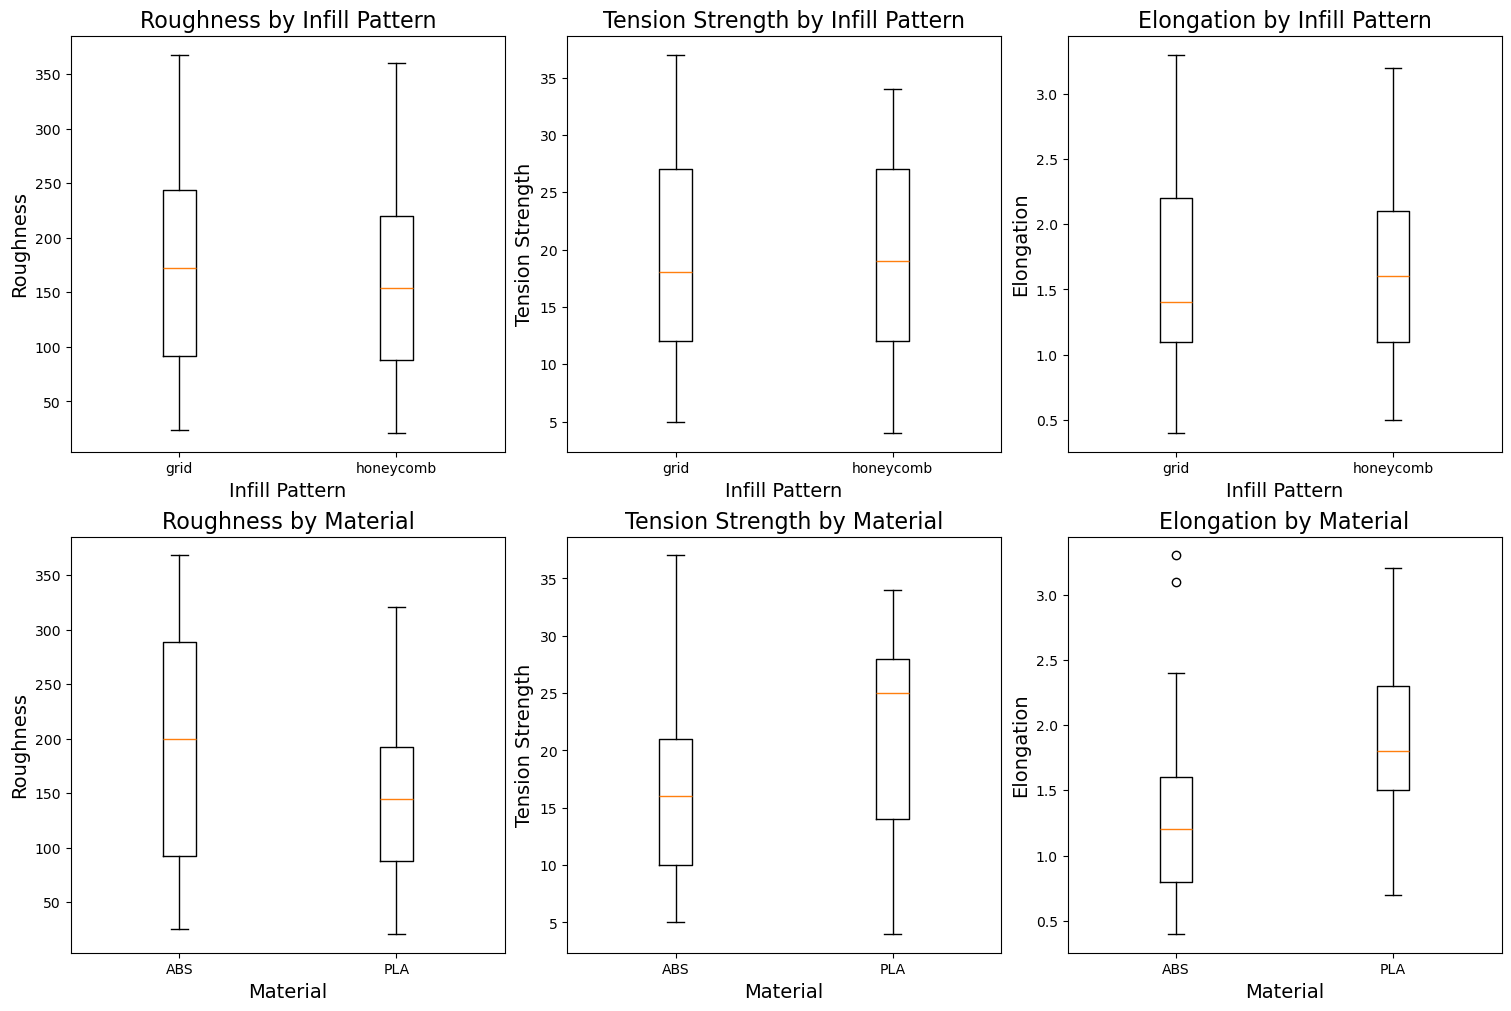

In [17]:
# Variables and targets
group_vars = ['infill_pattern', 'material']
targets = ['roughness', 'tension_strength', 'elongation']

# Create subplots grid: rows for group_vars, columns for targets
fig, axes = plt.subplots(
    len(group_vars),
    len(targets),
    figsize=(5 * len(targets), 5 * len(group_vars)),
    constrained_layout=True
)

# If only one row or one column, ensure axes is 2D
if axes.ndim == 1:
    axes = axes.reshape(len(group_vars), -1)

# Plot boxplots for each combination
for i, group in enumerate(group_vars):
    categories = sorted(df[group].unique())
    for j, col in enumerate(targets):
        ax = axes[i, j]
        # collect data for each category
        data = [df[df[group] == cat][col] for cat in categories]
        
        ax.boxplot(data, tick_labels=categories)
        ax.set_xlabel(group.replace('_', ' ').title(), fontsize=14)
        ax.set_ylabel(col.replace('_', ' ').title(), fontsize=14)
        ax.set_title(f'{col.replace("_", " ").title()} by {group.replace("_", " ").title()}', fontsize=16)

plt.show()

### A4. PLA parts average 147 vs. 193 roughness ($\approx$25% smoother), 22.6 vs. 17.5 MPa strength ($\approx$29% stronger), and 1.98 vs. 1.36 elongation ($\approx$45% more ductile) than ABS; honeycomb infill gives smaller gains (164 vs. 177 roughness; 20.2 vs. 20.0 MPa; 1.71 vs. 1.64 elongation). 

### Conclusion

Overall, our three targets exhibit distinct distributional shapes. Both **surface roughness and elongation** are **positively skewed**, while **tensile strength** is **essentially symmetric**, indicating different underlying process variability. The two key categorical factors **material** (PLA vs. ABS) and **infill pattern** (grid vs. honeycomb), are **evenly represented**, simplifying comparisons. Correlation analysis shows that roughness is driven most strongly by **layer height (r $\approx$ +0.80)**, tensile strength by **wall thickness (r $\approx$ +0.40)**, and elongation again by **layer height (r $\approx$ +0.51)**, with the **thermal settings (nozzle, bed, fan) largely redundant**. Finally, **PLA yields markedly better performance than ABS** ($\approx$25 % smoother, 29 % stronger, 45 % more ductile), and **honeycomb infill** provides modest additional gains over grid.